# Simple regression models - ShoreShop 2.0

Some simple regression models from old code. These are a nice baseline to explore the data, and get a feel for the process and alongshore behaviour. 
The code I have has the models estimate parameters for dx and then model y as:

`y = jnp.cumsum(f(x)) + e`

Things to deal with:

- check estimate y directly for the simplest models before building on dx style models
- autocorrelation in residuals (though low priority as not fussed about accuracy of uncertainty estimates)


- Check the reason for the years that spike very high and low
  - this appears to be at multiple profiles so I am fairly sure it it real, but need to correlate to certain events
  - seems to be some form of rotation or similar as the profile react together
- Can I use alongshore information in any way - like that was the shoreline predicted at the adjacent profiles last month.
  - spatial lagged autoregression
- NUTS appears the way and not SVI
- try simple onestep ahead vs autoregression

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from functions.data_load import load_modelling_data, tabularise_raw_data

from functions.inference.utils import (
    calc_skill,
    print_skill
)

## Load the data

Load the data using `load_modelling_data()` that returns a dictionary containing the following pandas DataFrames mirroring `1.data_explore.ipynb` (with indices as datetime objects where possible):

- `df_tran`: Transect data.
- `df_gt`: Groundtruth shoreline positions.
- `df_targ_short`: Short-term target shoreline positions.
- `df_targ_medium`: Medium-term target shoreline positions.
- `df_obs`: Observed shoreline positions.
- `dfs_wave`: Wave data for different parameters ('Hs', 'Tp', 'Dir').
- `df_SLR_obs`: Observed sea level rise data.
- `df_SLR_proj`: Projected sea level rise data.

Provided information:
A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [3]:
basedir = '.' # where are you in relation to the root directory
raw_data = load_modelling_data(basedir=basedir)

df_tran: Loaded 9 transects...
df_gt: Loaded (3, 9) (dates,transects) groundtruth shoreline positions...1999-06-20 to 2018-08-17
df_targ_short: Loaded (118, 9) (dates,transects) short-term target shoreline positions...2019-01-15 to 2023-12-28
df_targ_medium: Loaded (114, 9) (dates,transects) medium-term target shoreline positions...1951-05-01 to 1998-10-27
df_obs: Loaded (347, 9) (dates,transects) observed shoreline positions...1999-02-17 to 2018-12-30
dfs_wave["Hs"]: Loaded (30678, 9) (dates,transects) Hs wave data...
dfs_wave["Tp"]: Loaded (30678, 9) (dates,transects) Tp wave data...
dfs_wave["Dir"]: Loaded (30678, 9) (dates,transects) Dir wave data...
Wave data spans: 1940-01-02 to 2023-12-29 at 1 day(s) interval
df_SLR_obs: Loaded (69, 1) (years, ['Sealevel (m)']) observed sea level rise data...1950 to 2018
df_SLR_proj: Loaded (81, 2) (years, ['RCP45', 'RCP85']) projected sea level rise data...2019 to 2099


## Optional preprocessing
Here is provided a template for optional preprocessing steps that can be used to tabularise the data for modelling. Adopted the frequency of the wave data, but this can of course be adjusted.

In [4]:
# Optional pre-processing
tabular_data = tabularise_raw_data(raw_data)

<Axes: xlabel='date', ylabel='shoreline'>

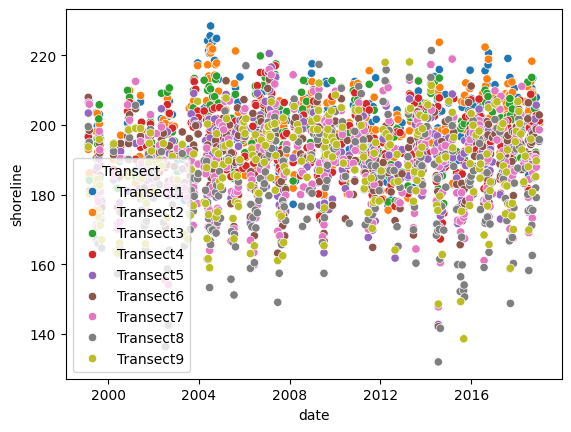

In [5]:
sns.scatterplot(tabular_data['df_obs'], hue='Transect', x='date', y='shoreline')

### Quick visualisation
Some quick visualisation of the data to show the format

We have daily data with intermittent shoreline position at 9 transects.

In [6]:
print(tabular_data.keys())
print(tabular_data['df_obs']['Transect'].unique())
tabular_data['df_obs']

dict_keys(['df_obs', 'df_targ_short', 'df_targ_medium'])
['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']


,date,Transect,shoreline,Hs,Tp,Dir
0,1999-02-17,Transect1,197.025794,1.278391,10.180599,87.879170
1,1999-02-18,Transect1,NaN,1.613118,10.515673,109.377224
2,1999-02-19,Transect1,NaN,1.384905,10.275089,127.935891
3,1999-02-20,Transect1,NaN,0.965775,9.764103,110.974377
4,1999-02-21,Transect1,NaN,1.222583,9.606054,106.006189
...,...,...,...,...,...,...
65308,2018-12-26,Transect9,NaN,1.200796,10.247938,99.339025
65309,2018-12-27,Transect9,NaN,1.208491,6.375795,85.126659
65310,2018-12-28,Transect9,NaN,1.313490,7.214175,71.430210
65311,2018-12-29,Transect9,NaN,1.338269,7.584354,73.688101


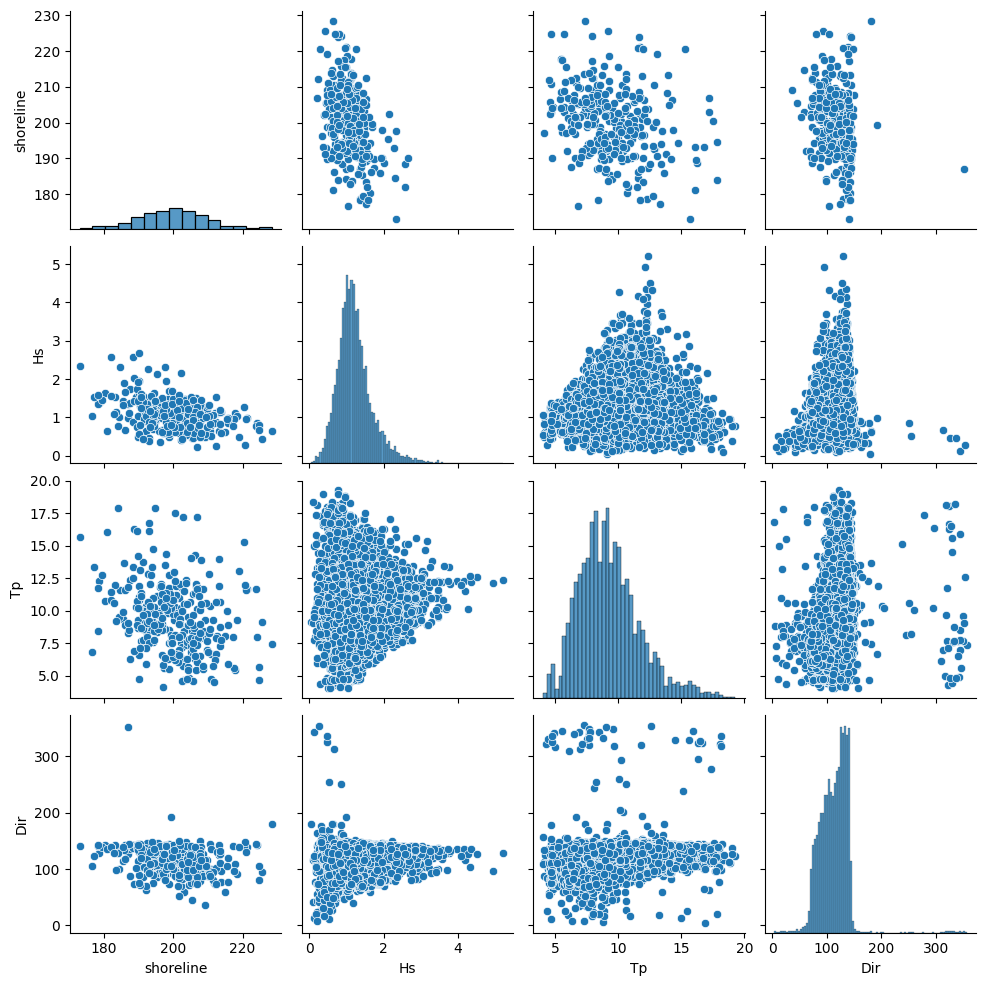

In [7]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

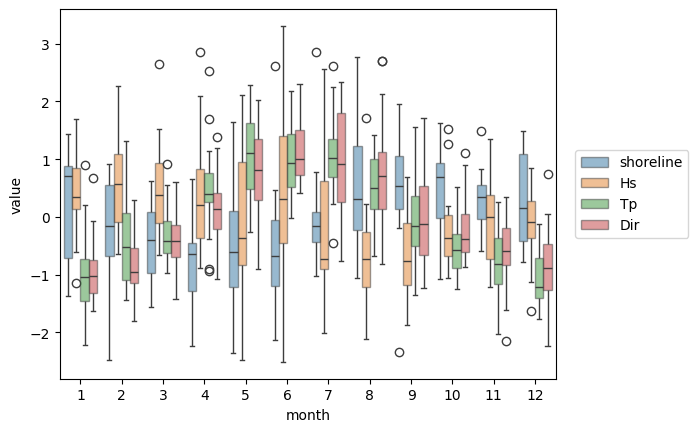

In [8]:
# plot the seasonal averages
trans_id = 'Transect1'
plot_data = tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('1ME').mean()
plot_data = plot_data.assign(month=plot_data.index.month)
# demean and stanardise the variables
for _ in [_ for _ in plot_data.columns if not _ in ['month']]:
    plot_data[_] = (plot_data[_] - plot_data[_].mean())/plot_data[_].std()
sns.boxplot(data=plot_data.melt(id_vars='month'),x='month',y='value',hue='variable',boxprops=dict(alpha=.5))
plt.legend(loc=6,bbox_to_anchor=(1.025,0.5))
plt.show()

### Prepare the data
Initially I will resample to monthly to avoid so many NaNs and other unpleasantries. Then we will cheekily gap fill the data, this will be a big exercise in missing data and the choice around how this is handled needs to be considered carefully.

In [9]:
# calculate how many non NaN values at each transect
print(tabular_data['df_obs'].groupby('Transect').count())

           date  shoreline    Hs    Tp   Dir
Transect                                    
Transect1  7257        300  7204  7257  7257
Transect2  7257        306  7204  7257  7257
Transect3  7257        316  7202  7257  7257
Transect4  7257        318  7200  7257  7257
Transect5  7257        312  7197  7257  7257
Transect6  7257        302  7198  7257  7257
Transect7  7257        306  7198  7257  7257
Transect8  7257        303  7198  7257  7257
Transect9  7257        253  7198  7257  7257


In [10]:
# split per Transect then average to monthly values with mean and peak for Hs and Tp then recombine into a reasonable dataframe
resampled_data = tabular_data['df_obs'].copy()
resampled_data = pd.concat(
    [
        resampled_data.query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('MS').agg({'Hs':['mean','max'],'Tp':['mean','max'],'Dir':['mean'],'shoreline':['mean']}).reset_index().assign(Transect=trans_id) for trans_id in resampled_data['Transect'].unique()
    ], axis=0
)
# combine the column names to make one level
resampled_data.columns = [
    '_'.join(col).strip() if '' != col[1] else col[0] for col in resampled_data.columns.values]
resampled_data = resampled_data.rename(columns={'shoreline_mean':'shoreline'})
# now add month predictor
resampled_data = resampled_data.assign(month=resampled_data['date'].dt.month-1)
resampled_data = resampled_data.reset_index(drop=True)
# get the shoreline position at t-1 but only for the same transect
resampled_data = resampled_data.assign(shoreline_tminus1=resampled_data.groupby('Transect')['shoreline'].shift(1))
# Keep only Transect6
resampled_data = resampled_data.query('Transect == "Transect6"').reset_index(drop=True)
resampled_data

,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
0,1999-02-01,1.665054,2.758835,10.331275,11.470636,110.185422,207.902414,Transect6,1,NaN
1,1999-03-01,1.278668,1.830194,8.823113,16.567677,111.008006,198.473587,Transect6,2,207.902414
2,1999-04-01,1.779084,3.863911,10.535254,16.258834,122.094301,NaN,Transect6,3,198.473587
3,1999-05-01,1.175998,2.823280,10.878827,18.975152,107.719703,NaN,Transect6,4,NaN
4,1999-06-01,1.236724,2.120187,9.389232,12.280586,124.941375,175.541281,Transect6,5,NaN
...,...,...,...,...,...,...,...,...,...,...
234,2018-08-01,1.018845,2.537602,10.632966,15.205031,115.460794,194.359078,Transect6,7,192.396233
235,2018-09-01,1.117118,1.707541,9.173348,15.854049,113.839695,196.268481,Transect6,8,194.359078
236,2018-10-01,1.442142,2.312759,9.055390,15.400205,107.096942,196.422823,Transect6,9,196.268481
237,2018-11-01,1.154757,2.592545,8.715568,18.908616,113.765841,195.194156,Transect6,10,196.422823


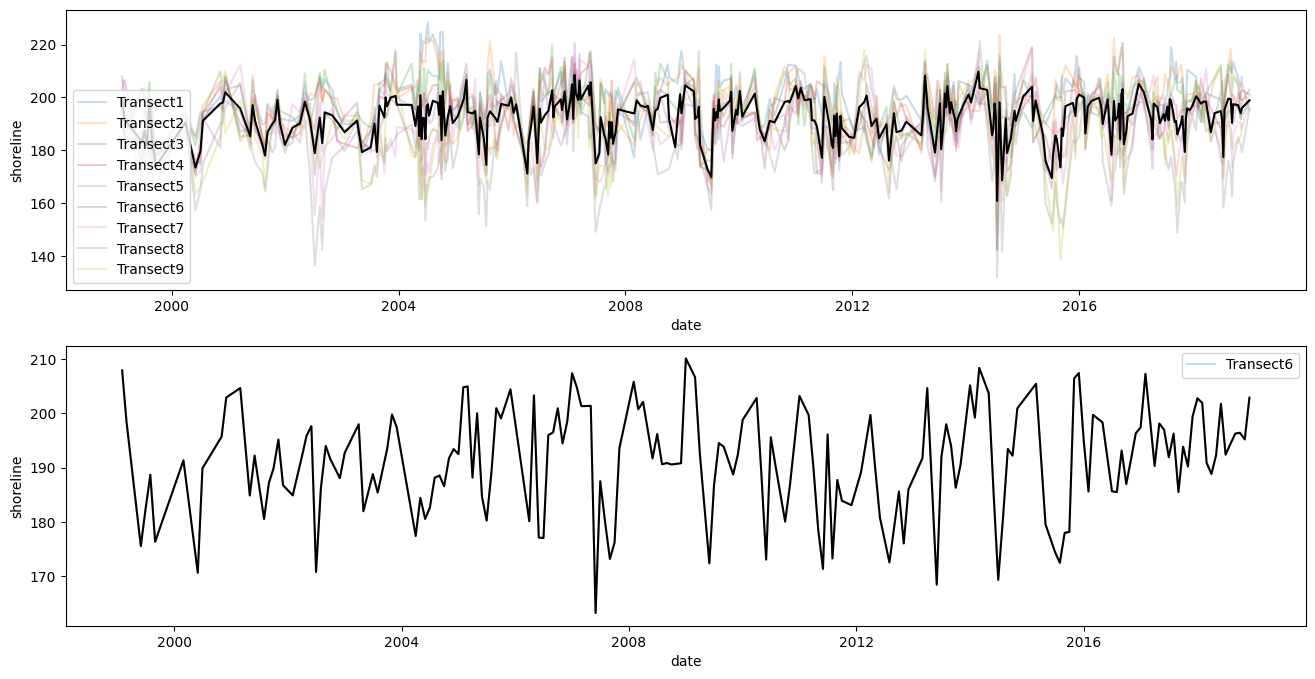

In [11]:
# vis of transect data
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', hue='Transect', ax=ax1, alpha=0.25)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', ax=ax1, color = 'k', errorbar=None)

sns.lineplot(data=resampled_data,y='shoreline', x='date', hue='Transect', ax=ax2, alpha=0.25)
sns.lineplot(data=resampled_data,y='shoreline', x='date', ax=ax2, color = 'k', errorbar=None)
sns.lineplot(data=resampled_data.query('Transect == "Transect1"'),y='shoreline', x='date', color = 'C0', ax=ax2, alpha=0.75)
sns.lineplot(data=resampled_data.query('Transect == "Transect9"'),y='shoreline', x='date', color = 'C3', ax=ax2, alpha=0.75)
plt.show()



In [12]:
# Split into training 1999-2016 and testing 2017-2019
train_data = resampled_data.query('date < "2017-01-01"').reset_index(drop=True)
test_data = resampled_data.query('date >= "2017-01-01"').reset_index(drop=True)

# Create the modelling copies

In [13]:
train_data_clean = train_data.dropna().copy()
test_data_clean = test_data.dropna().copy()
train_data_out = train_data_clean.copy()
test_data_out = test_data_clean.copy()

display(train_data_clean)
display(test_data_clean)

,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
1,1999-03-01,1.278668,1.830194,8.823113,16.567677,111.008006,198.473587,Transect6,2,207.902414
5,1999-07-01,1.430653,4.266294,9.882236,16.704792,120.954824,182.261587,Transect6,6,175.541281
6,1999-08-01,1.142860,1.938772,9.011568,16.063741,124.300761,188.669321,Transect6,7,182.261587
7,1999-09-01,1.230036,2.014325,9.508056,12.772402,102.857865,176.337101,Transect6,8,188.669321
17,2000-07-01,1.396648,3.453626,10.455007,12.491650,114.065257,189.880514,Transect6,6,170.623539
...,...,...,...,...,...,...,...,...,...,...
210,2016-08-01,1.052105,2.570240,8.857777,12.471019,115.971933,185.482622,Transect6,7,185.642403
211,2016-09-01,1.006969,1.988902,9.481770,17.855107,112.074970,193.138758,Transect6,8,185.482622
212,2016-10-01,1.064793,2.686638,9.353525,17.658770,115.028670,186.977146,Transect6,9,193.138758
213,2016-11-01,1.041543,1.668478,9.582727,15.267521,115.759530,191.651840,Transect6,10,186.977146


,date,Hs_mean,Hs_max,Tp_mean,Tp_max,Dir_mean,shoreline,Transect,month,shoreline_tminus1
0,2017-01-01,1.225549,1.727297,8.471786,13.481705,109.580011,197.402081,Transect6,0,196.334450
1,2017-02-01,1.196578,2.062899,8.198884,15.368516,105.112613,207.270632,Transect6,1,197.402081
4,2017-05-01,1.081825,1.900540,10.589425,17.444984,115.849794,198.134731,Transect6,4,190.307584
5,2017-06-01,1.273036,1.940535,10.507643,16.888633,119.911967,196.972057,Transect6,5,198.134731
6,2017-07-01,0.951685,2.663636,10.234870,16.943267,133.733832,191.909676,Transect6,6,196.972057
7,2017-08-01,1.188955,3.031325,10.584766,22.339769,134.610056,196.264888,Transect6,7,191.909676
8,2017-09-01,0.999867,1.992924,10.706339,15.897609,119.837908,185.507672,Transect6,8,196.264888
9,2017-10-01,1.161167,1.779323,8.162207,12.116338,110.732159,193.860097,Transect6,9,185.507672
10,2017-11-01,1.241979,2.251258,9.011896,15.456492,107.098042,190.208048,Transect6,10,193.860097
11,2017-12-01,1.214778,1.900583,7.909000,11.989455,92.813171,199.433208,Transect6,11,190.208048


## Modelling attempt
Here you can construct your model and make some predictions.

In [15]:
# Assuming train_data and test_data are already defined DataFrames
# Define the feature matrix X and target vector y
X_train = train_data_clean.drop(columns=['shoreline', 'date', 'Transect'])
y_train = train_data_clean['shoreline']
X_test = test_data_clean.drop(columns=['shoreline', 'date', 'Transect'])

# Initialize the scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale the feature matrix and target vector
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Create and train the linear regression model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train_scaled)

# Prepare the test data
X_test_scaled = scaler_X.transform(X_test)

# Make predictions on the test data
predictions_scaled = model.predict(X_test_scaled)
# Rescale the predictions back to the original scale
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# If you want to add the predictions to the test_data DataFrame
test_data_out['predicted_shoreline'] = predictions

# Make predictions on the training data
predictions_scaled_train = model.predict(X_train_scaled)
# Rescale the predictions back to the original scale
predictions_train = scaler_y.inverse_transform(predictions_scaled_train.reshape(-1, 1))
train_data_out['predicted_shoreline'] = predictions_train

# Display the first few rows of the test_data with predictions
print(train_data_out.head())
print(test_data_out.head())

         date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
1  1999-03-01  1.278668  1.830194   8.823113  16.567677  111.008006   
5  1999-07-01  1.430653  4.266294   9.882236  16.704792  120.954824   
6  1999-08-01  1.142860  1.938772   9.011568  16.063741  124.300761   
7  1999-09-01  1.230036  2.014325   9.508056  12.772402  102.857865   
17 2000-07-01  1.396648  3.453626  10.455007  12.491650  114.065257   

     shoreline   Transect  month  shoreline_tminus1  predicted_shoreline  
1   198.473587  Transect6      2         207.902414           198.030980  
5   182.261587  Transect6      6         175.541281           183.192088  
6   188.669321  Transect6      7         182.261587           187.958126  
7   176.337101  Transect6      8         188.669321           180.343993  
17  189.880514  Transect6      6         170.623539           187.493380  
        date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
0 2017-01-01  1.225549  1.727297   8.471786  13.48170

/Users/josh/miniconda3/envs/numpyro/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Plot predicted

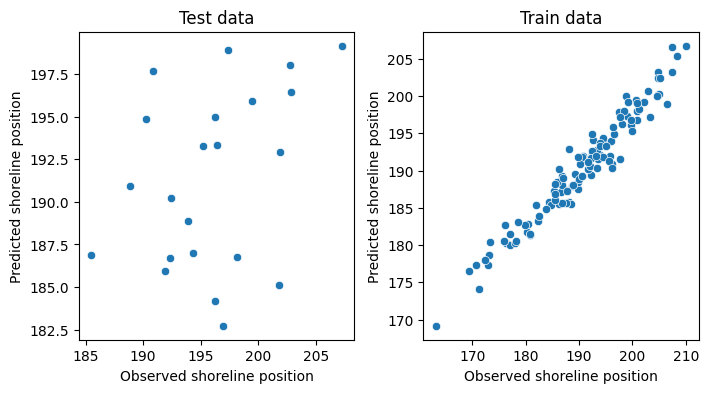

In [16]:
# Scatter plot of the predicted vs. observed shoreline positions
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.scatterplot(data=test_data_out, x='shoreline', y='predicted_shoreline', ax=ax1)
sns.scatterplot(data=train_data_out, x='shoreline', y='predicted_shoreline', ax=ax2)

ax1.set_title('Test data')
ax2.set_title('Train data')

ax1.set_xlabel('Observed shoreline position')
ax1.set_ylabel('Predicted shoreline position')
ax2.set_xlabel('Observed shoreline position')
ax2.set_ylabel('Predicted shoreline position')

plt.subplots_adjust(wspace=0.25)
plt.show()

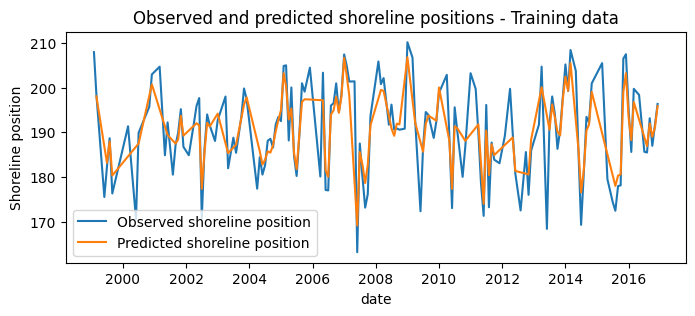

In [17]:
# Plot timeseries of observed and predicted shoreline positions
plt.figure(figsize=(8, 3))
sns.lineplot(data=train_data, x='date', y='shoreline', label='Observed shoreline position')
sns.lineplot(data=train_data_out, x='date', y='predicted_shoreline', label='Predicted shoreline position')
plt.ylabel('Shoreline position')
plt.title('Observed and predicted shoreline positions - Training data')
plt.show()

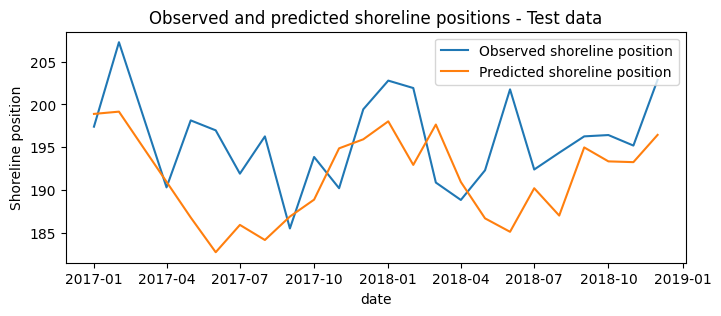

In [18]:
# Plot timeseries of observed and predicted shoreline positions
plt.figure(figsize=(8, 3))
sns.lineplot(data=test_data, x='date', y='shoreline', label='Observed shoreline position')
sns.lineplot(data=test_data_out, x='date', y='predicted_shoreline', label='Predicted shoreline position')
plt.ylabel('Shoreline position')
plt.title('Observed and predicted shoreline positions - Test data')
plt.show()

### Compare model skill
Compare the skill of each model by RMSE, R2 (of dShl), BSS.

In [19]:
# report the RMSE, BSS and R2
print('#'*80)
print('Train - one step')
rmse, r2, bss, r = calc_skill(
    curr_obs=train_data_out['shoreline'],
    prev_obs=train_data_out['shoreline_tminus1'],
    mean_mu=train_data_out['predicted_shoreline'].values
)
print('BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f} | r: {:.2f}'.format(bss,rmse,r2,r))
print('#'*80)
print('Test - one step')
rmse, r2, bss, r = calc_skill(
    curr_obs=test_data_out['shoreline'],
    prev_obs=test_data_out['shoreline_tminus1'],
    mean_mu=test_data_out['predicted_shoreline'].values
)
print('BSS: {:.2f} | RMSE: {:.2f} | R2: {:.2f} | r: {:.2f}'.format(bss,rmse,r2,r))

################################################################################
Train - one step
BSS: 0.93 | RMSE: 3.01 | R2: 0.86 | r: 0.97
################################################################################
Test - one step
BSS: -0.38 | RMSE: 7.45 | R2: -0.51 | r: 0.35
